<a href="https://colab.research.google.com/github/yakimsanik/belhard/blob/master/HW5/Yakim_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
pip install catboost

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, HuberRegressor, ElasticNet, PassiveAggressiveRegressor, OrthogonalMatchingPursuit
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Загрузка датасета
shark_attacks = pd.read_csv('/content/drive/MyDrive/Project/Data Science/HW5/global_shark_attacks.csv', encoding='latin1')

In [6]:
# Предварительный просмотр данных
print(shark_attacks.head())
print("\nИнформация о датасете:")
print(shark_attacks.info())
print("\nОписательная статистика:")
print(shark_attacks.describe(include='all'))

         date    year        type    country                area  \
0  2023-05-13  2023.0  Unprovoked  AUSTRALIA     South Australia   
1  2023-04-29  2023.0  Unprovoked  AUSTRALIA   Western Australia   
2  2022-10-07  2022.0  Unprovoked  AUSTRALIA  Western  Australia   
3  2021-10-04  2021.0  Unprovoked        USA             Florida   
4  2021-10-03  2021.0  Unprovoked        USA             Florida   

                                   location      activity                name  \
0                                  Elliston       Surfing    Simon Baccanello   
1                      Yallingup, Busselton      Swimming                male   
2                              Port Hedland  Spearfishing         Robbie Peck   
3  Fort Pierce State Park, St. Lucie County       Surfing  Truman Van Patrick   
4               Jensen Beach, Martin County      Swimming                male   

  sex   age fatal_y_n   time      species  
0   M    46         Y  10h10  White shark  
1   M   NaN     

In [7]:
# Предобработка данных
# Удаление строк с пропущенными значениями в целевой переменной
# Предположим, что целевая переменная - 'age'
data = pd.read_csv('/content/drive/MyDrive/Project/Data Science/HW5/global_shark_attacks.csv', encoding='latin1')
data = data.dropna(subset=['age'])

In [8]:
 #Функция для преобразования строкового возраста в числовой
def clean_age(age):
    if pd.isna(age):
        return np.nan
    if isinstance(age, (int, float)):
        return float(age)

    # Удаляем все нечисловые символы (кроме точки и минуса)
    cleaned = re.sub(r'[^\d.-]', '', str(age))
    try:
        return float(cleaned) if cleaned else np.nan
    except:
        return np.nan

# Применяем функцию очистки к столбцу age
if 'age' in data.columns:
    data['age'] = data['age'].apply(clean_age)
    data = data.dropna(subset=['age'])
else:
    raise ValueError("Столбец 'age' не найден в данных.")


In [9]:
# Пример: используем 'year' и 'fatal_y_n' для предсказания 'age'
X = data[['year', 'fatal_y_n']]
y = data['age']

In [10]:
# Кодирование категориальных признаков и масштабирование числовых
numeric_features = ['year']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['fatal_y_n']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [11]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Список моделей для сравнения
models = {
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'LGBM': LGBMRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Lasso': Lasso(random_state=42),
    'Ridge': Ridge(random_state=42),
    'Bayesian Ridge': BayesianRidge(),
    'Linear Regression': LinearRegression(),
    'Huber Regressor': HuberRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Orthogonal Matching Pursuit': OrthogonalMatchingPursuit(),
    'Passive Aggressive Regressor': PassiveAggressiveRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'Dummy Regressor': DummyRegressor(),
    'Elastic Net': ElasticNet(random_state=42),
}


In [13]:
# Ансамбль моделей
ensemble = VotingRegressor(estimators=[
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42))
])
models['Ensemble'] = ensemble

In [16]:
# Обучение и оценка моделей
results = []
for name, model in models.items():
    try:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('regressor', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append({'Model': name, 'MSE': mse, 'R2': r2})
    except Exception as e:
        print(f"Ошибка в модели {name}: {e}")
        results.append({'Model': name, 'MSE': np.nan, 'R2': np.nan})

# Создание DataFrame с результатами
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R2', ascending=False)

# Вывод результатов
print(results_df)

Ошибка в модели Gradient Boosting: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 

In [18]:
# Удаление строк с NaN
X_train = X_train.dropna()
y_train = y_train[X_train.index]

X_test = X_test.dropna()
y_test = y_test[X_test.index]

In [19]:
# Обучение и оценка моделей
results = []
for name, model in models.items():
    try:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('regressor', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append({'Model': name, 'MSE': mse, 'R2': r2})
    except Exception as e:
        print(f"Ошибка в модели {name}: {e}")
        results.append({'Model': name, 'MSE': np.nan, 'R2': np.nan})

# Создание DataFrame с результатами
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R2', ascending=False)

# Вывод результатов
print(results_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 3084, number of used features: 4
[LightGBM] [Info] Start training from score 1221794.541936
                           Model           MSE           R2
6                       AdaBoost  5.900227e+11    -0.001297
11               Huber Regressor  5.900239e+11    -0.001299
14  Passive Aggressive Regressor  5.900244e+11    -0.001300
9                 Bayesian Ridge  2.015140e+12    -2.419790
16               Dummy Regressor  2.015140e+12    -2.419790
17                   Elastic Net  2.968726e+12    -4.038071
8                          Ridge  3.086675e+13   -51.382363
10             Linear Regression  3.110507e+13   -51.786791
7                          Lasso  3.110862e+13   -51.792826
13   Orthogonal Matching Pursuit  3.115695e+13   -51.87

В датасете присутствуют значения например, 2023.0, 2022.0  которые используются как целевая переменная для регрессии. Однако предсказание года атаки акулы не имеет практического смысла, так как это временная метка, а не числовая характеристика. Это приводит к абсурдно высоким значениям MSE и отрицательным R2 что указывает на полную неадекватность моделей.
Регрессия для предсказания года не подходит для этого датасета.

Попробуем другой датасет

In [61]:
import kagglehub
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [63]:
path = kagglehub.dataset_download("loveall/appliances-energy-prediction")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/appliances-energy-prediction


In [64]:
# Загрузка датасета
data = pd.read_csv('/content/drive/MyDrive/Project/Data Science/HW5/KAG_energydata_complete.csv', encoding='latin1')

In [65]:
# Удаление ненужных столбцов (дата и время)
data = data.drop(columns=["date"])

In [66]:
# Разделение на признаки (X) и целевую переменную (y)
X = data.drop(columns=["Appliances"])  # Все колонки, кроме целевой
y = data["Appliances"]  # Целевая переменная — энергопотребление

In [67]:
# Разделение на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [59]:
# Инициализация моделей
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Support Vector Machine": SVR(kernel="rbf", C=1.0)
}


In [69]:
# Сравнение моделей
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Вычисляем RMSE вручную
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R2": round(r2, 4)
    })

In [70]:
# Результаты в виде таблицы
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="R2", ascending=False))

                    Model      MSE   RMSE    MAE      R2
1           Random Forest  4674.46  68.37  32.90  0.5329
3     K-Nearest Neighbors  6617.24  81.35  38.89  0.3387
2       Gradient Boosting  7402.28  86.04  47.21  0.2603
0       Linear Regression  8312.85  91.17  52.55  0.1693
4  Support Vector Machine  9734.04  98.66  42.30  0.0273


Для наглядности добавим график сравнения моделей по R²:

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
# Сортировка по R2
results_df = results_df.sort_values(by="R2", ascending=False)

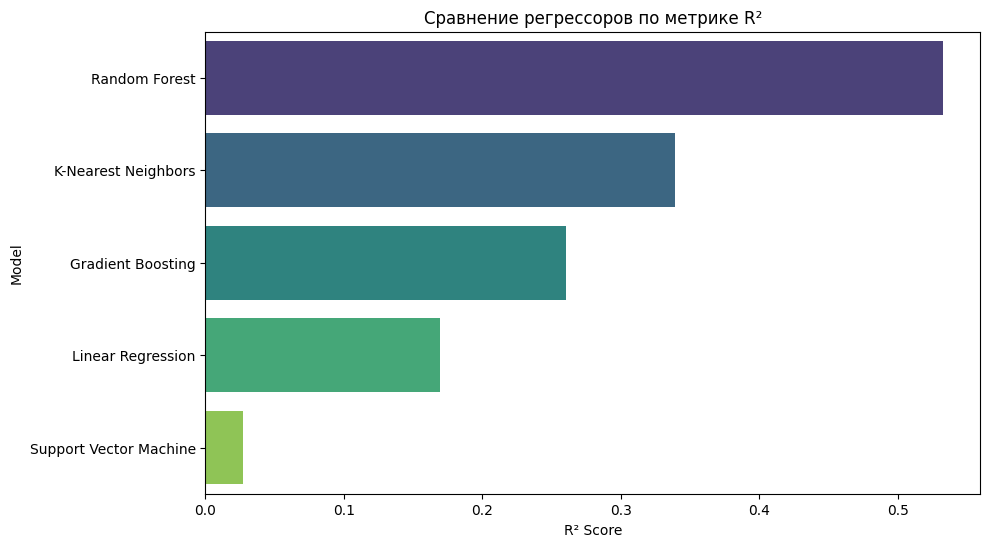

In [73]:
# График
plt.figure(figsize=(10, 6))
sns.barplot(x="R2", y="Model", data=results_df, palette="viridis")
plt.title("Сравнение регрессоров по метрике R²")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.show()

Random Forest показал себя как наиболее эффективная модель для данного набора данных.
SVM показала наихудшие результаты, возможно, не подходит для данной задачи.